# 3D Multi-class Segmentation with UNETR in MR (Muscle, Fat (subcut and internal),psoas,Cavity and Bgd)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory


In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


## Setup transforms for training and validation

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=200,
            b_min=0.0,
            b_max=1.0,
            clip=False,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(48, 48, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                              | 0/6 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]


In [6]:
print(data_dir)

/home/adminbthomas/Downloads/data/013123_MR/


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 49]), label shape: torch.Size([1, 250, 176, 49])


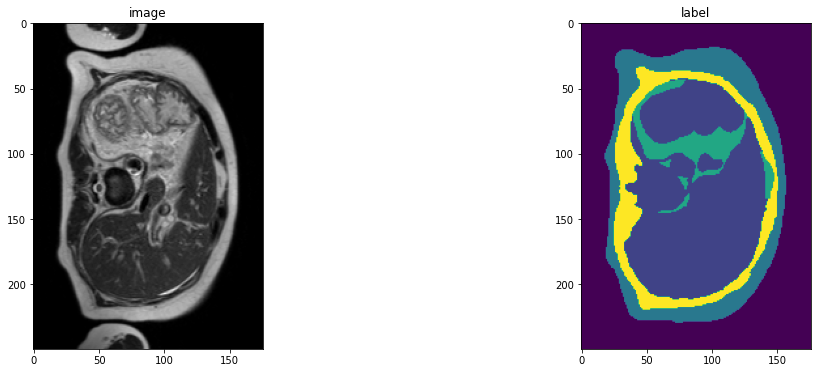

In [7]:
slice_map = {
    "A016_v3_T2W.nii.gz": 10,
    "A016_v3_T2W.nii.gz": 25,
    "A016_v3_T2W.nii.gz": 40
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
# img = img[:,:,:,:,0]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

model = UNETR(
    in_channels=1,
    out_channels=6,
    img_size=(48, 48, 48),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (48, 48, 48), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR01.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 35000
eval_num = 200
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR01.pth")))

Training (201 / 35000 Steps) (loss=2.46486):  67%|████████████████████████████              | 4/6 [00:04<00:02,  1.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.38221072405576706 Current Avg. Dice: 0.38221072405576706


Training (401 / 35000 Steps) (loss=2.40082): 100%|██████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


Model Was Saved ! Current Best Avg. Dice: 0.4229312017560005 Current Avg. Dice: 0.4229312017560005


Training (601 / 35000 Steps) (loss=1.84643):  33%|██████████████                            | 2/6 [00:03<00:06,  1.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4731709063053131 Current Avg. Dice: 0.4731709063053131


Training (801 / 35000 Steps) (loss=2.04487):  67%|████████████████████████████              | 4/6 [00:03<00:02,  1.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5081835389137268 Current Avg. Dice: 0.5081835389137268


Training (1001 / 35000 Steps) (loss=1.58638): 100%|█████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


Model Was Saved ! Current Best Avg. Dice: 0.5139643624424934 Current Avg. Dice: 0.5139643624424934


Training (1201 / 35000 Steps) (loss=1.58649):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5139643624424934 Current Avg. Dice: 0.5134375542402267


Training (1401 / 35000 Steps) (loss=1.42727):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.00it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5402717739343643 Current Avg. Dice: 0.5402717739343643


Training (1601 / 35000 Steps) (loss=1.41882): 100%|█████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]


Model Was Saved ! Current Best Avg. Dice: 0.5442676842212677 Current Avg. Dice: 0.5442676842212677


Training (1801 / 35000 Steps) (loss=1.41775):  33%|█████████████▋                           | 2/6 [00:03<00:06,  1.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5543989539146423 Current Avg. Dice: 0.5543989539146423


Training (2001 / 35000 Steps) (loss=2.10186):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.02it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5590744614601135 Current Avg. Dice: 0.5590744614601135


Training (2201 / 35000 Steps) (loss=1.71437): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.5590744614601135 Current Avg. Dice: 0.5332490652799606


Training (2401 / 35000 Steps) (loss=1.12843):  33%|█████████████▋                           | 2/6 [00:03<00:06,  1.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5769157856702805 Current Avg. Dice: 0.5769157856702805


Training (2601 / 35000 Steps) (loss=1.20921):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5769157856702805 Current Avg. Dice: 0.5710206627845764


Training (2801 / 35000 Steps) (loss=1.29429): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.5769157856702805 Current Avg. Dice: 0.5757748037576675


Training (3001 / 35000 Steps) (loss=1.01016):  33%|█████████████▋                           | 2/6 [00:03<00:06,  1.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5905061066150665 Current Avg. Dice: 0.5905061066150665


Training (3201 / 35000 Steps) (loss=1.41246):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.02it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.6128819435834885


Training (3401 / 35000 Steps) (loss=1.56123): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.6049951612949371


Training (3601 / 35000 Steps) (loss=1.01548):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.5957932621240616


Training (3801 / 35000 Steps) (loss=2.08059):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.12it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.5961293429136276


Training (4001 / 35000 Steps) (loss=1.58028): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.5625726282596588


Training (4201 / 35000 Steps) (loss=0.94428):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.5963644832372665


Training (4401 / 35000 Steps) (loss=1.06430):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.5884065330028534


Training (4601 / 35000 Steps) (loss=1.29893): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.35it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6128819435834885 Current Avg. Dice: 0.6049389839172363


Training (4801 / 35000 Steps) (loss=0.82079):  33%|█████████████▋                           | 2/6 [00:03<00:06,  1.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.6187494248151779


Training (5001 / 35000 Steps) (loss=0.69285):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.6084535121917725


Training (5201 / 35000 Steps) (loss=1.13255): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.40it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.5705883502960205


Training (5401 / 35000 Steps) (loss=0.93918):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.6118768602609634


Training (5601 / 35000 Steps) (loss=1.29044):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.61247518658638


Training (5801 / 35000 Steps) (loss=1.49945): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.39it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6187494248151779 Current Avg. Dice: 0.5801348984241486


Training (6001 / 35000 Steps) (loss=0.79804):  33%|█████████████▋                           | 2/6 [00:03<00:06,  1.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.6362293660640717


Training (6201 / 35000 Steps) (loss=1.03556):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.610505685210228


Training (6401 / 35000 Steps) (loss=0.87889): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.5929679125547409


Training (6601 / 35000 Steps) (loss=1.92743):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.603420153260231


Training (6801 / 35000 Steps) (loss=1.70205):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.594576820731163


Training (7001 / 35000 Steps) (loss=1.13293): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.6203180998563766


Training (7201 / 35000 Steps) (loss=1.73265):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6362293660640717 Current Avg. Dice: 0.6330132484436035


Training (7401 / 35000 Steps) (loss=0.96974):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.00it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6391404271125793


Training (7601 / 35000 Steps) (loss=1.19070): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.5880128592252731


Training (7801 / 35000 Steps) (loss=0.88725):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.5789111852645874


Training (8001 / 35000 Steps) (loss=0.92807):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.10it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6033330410718918


Training (8201 / 35000 Steps) (loss=1.10935): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.33it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6384061425924301


Training (8401 / 35000 Steps) (loss=1.80340):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6121325343847275


Training (8601 / 35000 Steps) (loss=0.86797):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.13it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6226452142000198


Training (8801 / 35000 Steps) (loss=0.67549): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.34it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6214639097452164


Training (9001 / 35000 Steps) (loss=1.40304):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.5987875163555145


Training (9201 / 35000 Steps) (loss=0.71105):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.12it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.621293380856514


Training (9401 / 35000 Steps) (loss=0.91958): 100%|█████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6290568262338638


Training (9601 / 35000 Steps) (loss=1.71498):  33%|█████████████▋                           | 2/6 [00:03<00:05,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.5866632610559464


Training (9801 / 35000 Steps) (loss=2.03246):  67%|███████████████████████████▎             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6336897313594818


Training (10001 / 35000 Steps) (loss=1.35962): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.39it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6391404271125793 Current Avg. Dice: 0.6366215199232101


Training (10201 / 35000 Steps) (loss=0.72547):  33%|█████████████▎                          | 2/6 [00:03<00:06,  1.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6492830812931061


Training (10401 / 35000 Steps) (loss=0.96452):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.13it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6137803047895432


Training (10601 / 35000 Steps) (loss=0.75521): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.35it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.617112472653389


Training (10801 / 35000 Steps) (loss=0.94075):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6071058660745621


Training (11001 / 35000 Steps) (loss=1.70836):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.598772868514061


Training (11201 / 35000 Steps) (loss=0.61895): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.33it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6127185821533203


Training (11401 / 35000 Steps) (loss=1.26409):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6176243126392365


Training (11601 / 35000 Steps) (loss=0.88812):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6229063421487808


Training (11801 / 35000 Steps) (loss=1.08196): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6047107875347137


Training (12001 / 35000 Steps) (loss=1.03960):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6339491456747055


Training (12201 / 35000 Steps) (loss=1.74819):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.13it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.5990325510501862


Training (12401 / 35000 Steps) (loss=0.79180): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6147498190402985


Training (12601 / 35000 Steps) (loss=0.65082):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6278599500656128


Training (12801 / 35000 Steps) (loss=1.06285):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6371454000473022


Training (13001 / 35000 Steps) (loss=0.62560): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6269628554582596


Training (13201 / 35000 Steps) (loss=1.26097):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6212400645017624


Training (13401 / 35000 Steps) (loss=0.82589):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6125986725091934


Training (13601 / 35000 Steps) (loss=1.22332): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6059166640043259


Training (13801 / 35000 Steps) (loss=0.76089):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6064821034669876


Training (14001 / 35000 Steps) (loss=1.25855):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6378515213727951


Training (14201 / 35000 Steps) (loss=0.76947): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.623219221830368


Training (14401 / 35000 Steps) (loss=0.80114):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6144168525934219


Training (14601 / 35000 Steps) (loss=0.91460):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.5784529149532318


Training (14801 / 35000 Steps) (loss=1.26078): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.34it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6208729892969131


Training (15001 / 35000 Steps) (loss=1.04922):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6364503800868988


Training (15201 / 35000 Steps) (loss=0.92653):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6259055286645889


Training (15401 / 35000 Steps) (loss=0.71745): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.593757763504982


Training (15601 / 35000 Steps) (loss=0.43117):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.625309556722641


Training (15801 / 35000 Steps) (loss=0.63533):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6450627446174622


Training (16001 / 35000 Steps) (loss=1.31505): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6313211172819138


Training (16201 / 35000 Steps) (loss=0.78017):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.603263795375824


Training (16401 / 35000 Steps) (loss=0.92412):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.5993269234895706


Training (16601 / 35000 Steps) (loss=0.88394): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.38it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6492830812931061 Current Avg. Dice: 0.6079939156770706


Training (16801 / 35000 Steps) (loss=0.69329):  33%|█████████████▎                          | 2/6 [00:03<00:06,  1.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6543429344892502


Training (17001 / 35000 Steps) (loss=0.98500):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6376310437917709


Training (17201 / 35000 Steps) (loss=0.72480): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6295216232538223


Training (17401 / 35000 Steps) (loss=2.11326):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6140300035476685


Training (17601 / 35000 Steps) (loss=1.23480):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6425965279340744


Training (17801 / 35000 Steps) (loss=0.56310): 100%|████████████████████████████████████████| 6/6 [00:04<00:00,  1.46it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6520012766122818


Training (18001 / 35000 Steps) (loss=1.07901):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6389250755310059


Training (18201 / 35000 Steps) (loss=1.14627):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6341348588466644


Training (18401 / 35000 Steps) (loss=0.91670): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6243791729211807


Training (18601 / 35000 Steps) (loss=1.27710):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6543429344892502 Current Avg. Dice: 0.6191999614238739


Training (18801 / 35000 Steps) (loss=1.75621):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.01it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6556554585695267


Training (19001 / 35000 Steps) (loss=0.82823): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.38it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.633236438035965


Training (19201 / 35000 Steps) (loss=0.72138):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.5905217826366425


Training (19401 / 35000 Steps) (loss=0.80151):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6420404016971588


Training (19601 / 35000 Steps) (loss=0.55708): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.34it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6442527920007706


Training (19801 / 35000 Steps) (loss=0.99142):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6282510012388229


Training (20001 / 35000 Steps) (loss=0.94790):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.11it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.62149877846241


Training (20201 / 35000 Steps) (loss=0.56193): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.5995122790336609


Training (20401 / 35000 Steps) (loss=1.21206):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.5946647375822067


Training (20601 / 35000 Steps) (loss=0.93731):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6302788406610489


Training (20801 / 35000 Steps) (loss=0.70949): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6287601739168167


Training (21001 / 35000 Steps) (loss=0.52415):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.5994156301021576


Training (21201 / 35000 Steps) (loss=0.73534):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6118930280208588


Training (21401 / 35000 Steps) (loss=0.41803): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6269060373306274


Training (21601 / 35000 Steps) (loss=1.20508):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6021390110254288


Training (21801 / 35000 Steps) (loss=1.15201):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6490037441253662


Training (22001 / 35000 Steps) (loss=0.87097): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.54it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6284498870372772


Training (22201 / 35000 Steps) (loss=0.75367):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6464027911424637


Training (22401 / 35000 Steps) (loss=1.23688):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6267987787723541


Training (22601 / 35000 Steps) (loss=0.54783): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.35it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6260754615068436


Training (22801 / 35000 Steps) (loss=0.51781):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6514007896184921


Training (23001 / 35000 Steps) (loss=0.90609):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.18it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.6306009888648987


Training (23201 / 35000 Steps) (loss=1.61354): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6556554585695267 Current Avg. Dice: 0.5866496413946152


Training (23401 / 35000 Steps) (loss=0.74392):  33%|█████████████▎                          | 2/6 [00:03<00:06,  1.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6577403545379639 Current Avg. Dice: 0.6577403545379639


Training (23601 / 35000 Steps) (loss=2.31699):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.00it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6665889918804169


Training (23801 / 35000 Steps) (loss=0.96066): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6121349334716797


Training (24001 / 35000 Steps) (loss=0.70113):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6339846551418304


Training (24201 / 35000 Steps) (loss=1.69568):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6387962102890015


Training (24401 / 35000 Steps) (loss=0.62766): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6413736790418625


Training (24601 / 35000 Steps) (loss=0.56117):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6232046335935593


Training (24801 / 35000 Steps) (loss=0.81450):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.12it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6183511167764664


Training (25001 / 35000 Steps) (loss=0.69512): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6323320418596268


Training (25201 / 35000 Steps) (loss=0.87651):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6356343924999237


Training (25401 / 35000 Steps) (loss=0.77862):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6275207996368408


Training (25601 / 35000 Steps) (loss=0.62811): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.618635967373848


Training (25801 / 35000 Steps) (loss=0.45394):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6483088880777359


Training (26001 / 35000 Steps) (loss=0.86330):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6567024141550064


Training (26201 / 35000 Steps) (loss=1.22647): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.35it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6219796538352966


Training (26401 / 35000 Steps) (loss=0.70084):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6275308579206467


Training (26601 / 35000 Steps) (loss=1.28819):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.13it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.5770276635885239


Training (26801 / 35000 Steps) (loss=0.89154): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6343729645013809


Training (27001 / 35000 Steps) (loss=0.75588):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6490841954946518


Training (27201 / 35000 Steps) (loss=0.42034):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.17it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6556427925825119


Training (27401 / 35000 Steps) (loss=1.01476): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6095096319913864


Training (27601 / 35000 Steps) (loss=0.77016):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6457345336675644


Training (27801 / 35000 Steps) (loss=0.75993):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6288722306489944


Training (28001 / 35000 Steps) (loss=1.01519): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.616391658782959


Training (28201 / 35000 Steps) (loss=0.61475):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.649284228682518


Training (28401 / 35000 Steps) (loss=0.95218):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6368092894554138


Training (28601 / 35000 Steps) (loss=0.99556): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6500232219696045


Training (28801 / 35000 Steps) (loss=0.75693):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6665889918804169 Current Avg. Dice: 0.6549734175205231


Training (29001 / 35000 Steps) (loss=0.81468):  67%|██████████████████████████▋             | 4/6 [00:03<00:02,  1.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.6975007504224777


Training (29201 / 35000 Steps) (loss=0.49103): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.33it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.6433499157428741


Training (29401 / 35000 Steps) (loss=0.59844):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.6947229504585266


Training (29601 / 35000 Steps) (loss=0.89436):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.659656748175621


Training (29801 / 35000 Steps) (loss=0.79364): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.6390325129032135


Training (30001 / 35000 Steps) (loss=0.73983):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6975007504224777 Current Avg. Dice: 0.6557831317186356


Training (30201 / 35000 Steps) (loss=0.92319):  67%|██████████████████████████▋             | 4/6 [00:04<00:02,  1.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7048097103834152 Current Avg. Dice: 0.7048097103834152


Training (30401 / 35000 Steps) (loss=0.98545): 100%|████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


Model Was Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.7166693806648254


Training (30601 / 35000 Steps) (loss=0.80037):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.6847210824489594


Training (30801 / 35000 Steps) (loss=0.57804):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.6621858328580856


Training (31001 / 35000 Steps) (loss=0.64174): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.6424805521965027



Training (31201 / 35000 Steps) (loss=0.74285):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.669188916683197


Training (31401 / 35000 Steps) (loss=0.59214):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7166693806648254 Current Avg. Dice: 0.7129309773445129


Training (31601 / 35000 Steps) (loss=0.80879): 100%|████████████████████████████████████████| 6/6 [00:04<00:00,  1.19it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.7335681319236755


Training (31801 / 35000 Steps) (loss=0.77465):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.6417315900325775


Training (32001 / 35000 Steps) (loss=0.56668):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.16it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.7161455750465393


Training (32201 / 35000 Steps) (loss=0.86129): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.7255947589874268


Training (32401 / 35000 Steps) (loss=0.43484):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.695373922586441


Training (32601 / 35000 Steps) (loss=0.91400):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.721079632639885


Training (32801 / 35000 Steps) (loss=0.72699): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.6972294598817825


Training (33001 / 35000 Steps) (loss=1.54370):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.657159835100174


Training (33201 / 35000 Steps) (loss=1.43330):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.12it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7335681319236755 Current Avg. Dice: 0.6770862191915512


Training (33401 / 35000 Steps) (loss=1.10283): 100%|████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


Model Was Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7453226000070572


Training (33601 / 35000 Steps) (loss=0.82523):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7374102026224136


Training (33801 / 35000 Steps) (loss=0.62442):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.13it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7000106424093246


Training (34001 / 35000 Steps) (loss=0.66577): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7349493950605392


Training (34201 / 35000 Steps) (loss=0.56924):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.6827576160430908


Training (34401 / 35000 Steps) (loss=0.49336):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.17it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.6732839345932007


Training (34601 / 35000 Steps) (loss=0.52640): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7146630883216858


Training (34801 / 35000 Steps) (loss=0.73775):  33%|█████████████▎                          | 2/6 [00:03<00:05,  1.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7116686552762985


Training (35001 / 35000 Steps) (loss=0.97525):  67%|██████████████████████████▋             | 4/6 [00:03<00:01,  1.15it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7453226000070572 Current Avg. Dice: 0.7032438814640045


Training (35003 / 35000 Steps) (loss=0.58390): 100%|████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.7453 at iteration: 33400


In [ ]:
6062500/380133
12062500/731025
250*250*49
12062500/(250*250)

### Plot the loss and metric

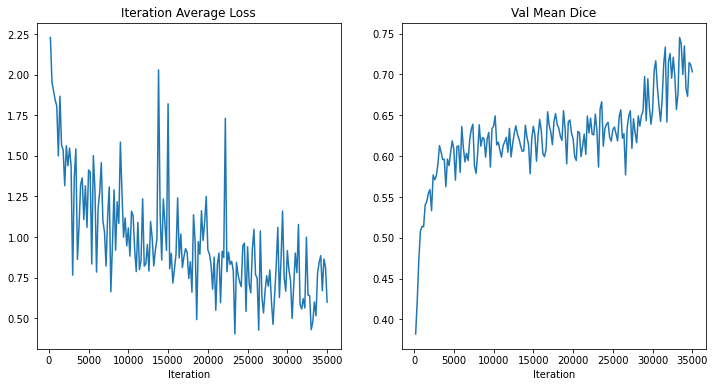

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

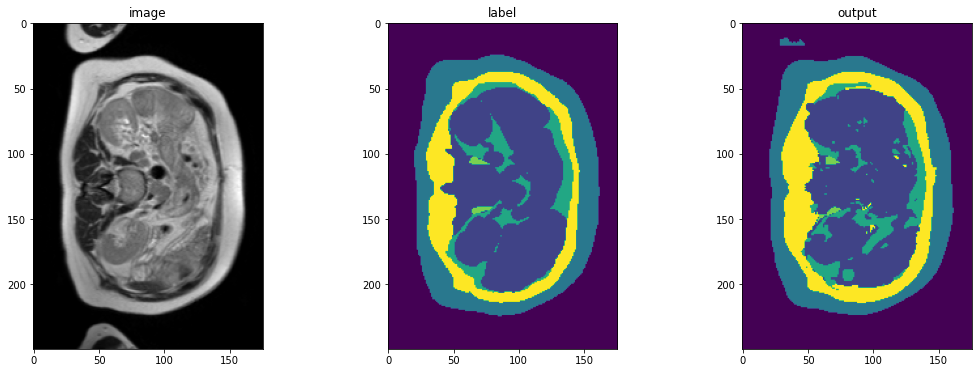

In [16]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR01.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (48, 48, 48), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()

In [ ]:
val_inputs.shape

### Inference on test images

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [17]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR01", output_postfix="seg", resample=False, separate_folder=False),
])

In [ ]:
print(data_dir)

2023-02-07 11:01:59,245 INFO image_writer.py:194 - writing: outMR01/A026_v1_T2W_seg.nii.gz


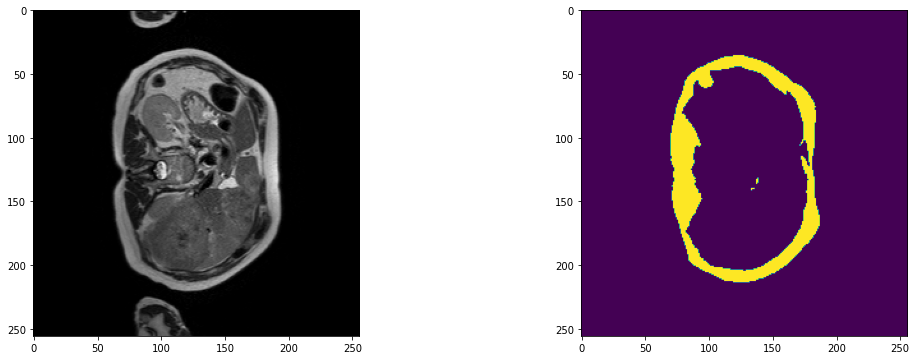

2023-02-07 11:02:03,699 INFO image_writer.py:194 - writing: outMR01/A028_v5_T2W_seg.nii.gz


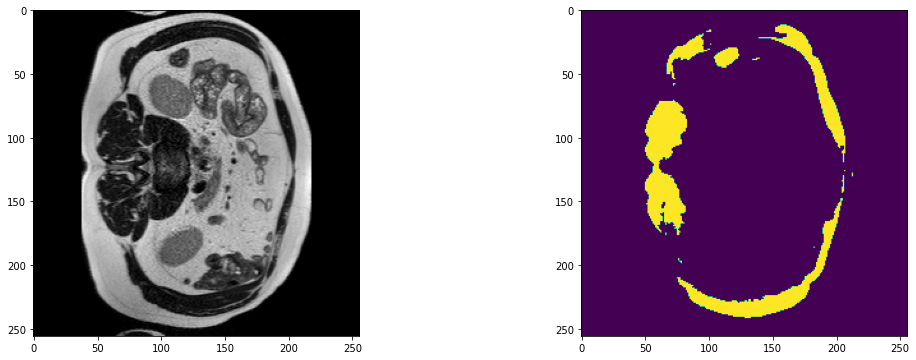

2023-02-07 11:02:07,896 INFO image_writer.py:194 - writing: outMR01/A029_v4_T2W_seg.nii.gz


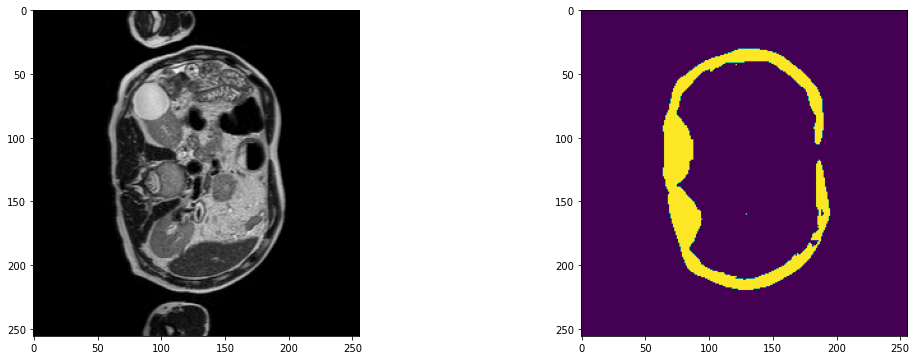

2023-02-07 11:02:22,047 INFO image_writer.py:194 - writing: outMR01/A033_v3_T2W_seg.nii.gz


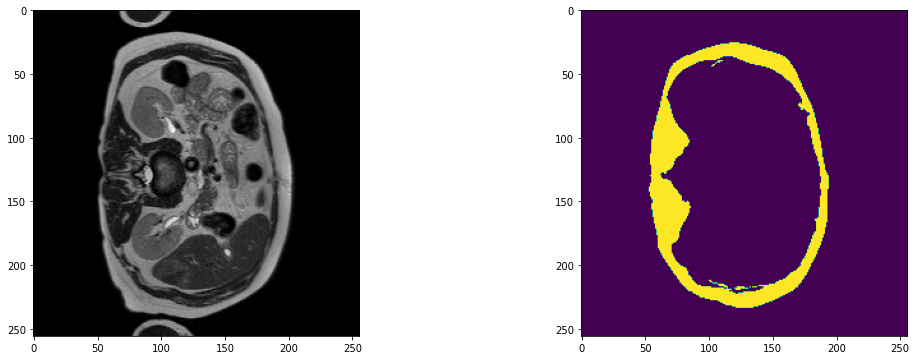

2023-02-07 11:02:36,432 INFO image_writer.py:194 - writing: outMR01/A034_v6_T2W_seg.nii.gz


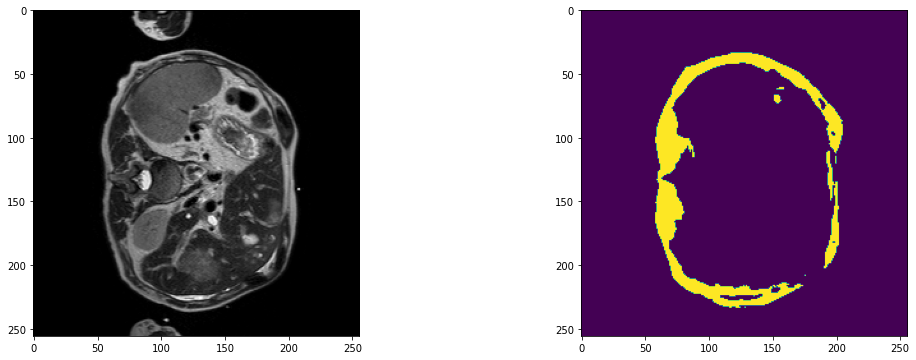

In [18]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR01.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (48, 48, 48)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
# Testing code modified  (Based on validation block)

from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR01.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (16, 16, 16)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8
    )
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 2, 1)
#     plt.title("image")
#     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 40], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("output")
#     plt.imshow(
#         torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 40]
#     )
#     plt.show()      

In [ ]:
plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(
    torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 20]
)
plt.show()

In [ ]:
print(test_output[0].shape)

In [ ]:
slno = 20
plt.figure("check1", (18, 6))
plt.imshow(original_image[:, :, slno], cmap="gray")
plt.figure("check2", (18, 6))
plt.subplot(3, 3, 1)
plt.imshow(test_output[0].detach().cpu()[0, :, :, slno])
plt.subplot(3, 3, 2)
plt.imshow(test_output[0].detach().cpu()[1, :, :, slno])
plt.subplot(3, 3, 3)
plt.imshow(test_output[0].detach().cpu()[2, :, :, slno])
plt.subplot(3, 3, 4)
plt.imshow(test_output[0].detach().cpu()[3, :, :, slno])
plt.subplot(3, 3, 5)
plt.imshow(test_output[0].detach().cpu()[4, :, :, slno])
plt.subplot(3, 3, 6)
plt.imshow(test_output[0].detach().cpu()[5, :, :, slno])
plt.subplot(3, 3, 7)
plt.imshow(test_output[0].detach().cpu()[6, :, :, slno])
plt.subplot(3, 3, 8)
plt.imshow(test_output[0].detach().cpu()[7, :, :, slno])
plt.subplot(3, 3, 9)
plt.imshow(test_output[0].detach().cpu()[8, :, :, slno])
plt.show()